## Model transformations
Let us stay with the linear ray tomography, but use nonlinear model transformations. 

In [117]:
using DelimitedFiles
using SparseArrays
using PyPlot
using LinearAlgebra
IJV = readdlm("jacobian.ijv")
J = sparse(IJV[:, 1].+1, IJV[:, 2].+1, IJV[:, 3]);
G = Matrix(J);  # make a dense matrix of it

In [118]:
x = 0:10;
y = 0:11;
nx = length(x) - 1
ny = length(y) - 1
function showModel(model, fixclim=true)
    matshow(transpose(reshape(model, nx, ny)))
    if fixclim
        clim(5, 25)
        set_cmap("Spectral_r")
    end
    colorbar();
    return
    end;

A nonlinear inversion scheme consists of iteratively solving a linearized inverse problem for the model change $\Delta{\bf m}$ as a function of the data misfit $\Delta{\bf d}={\bf d}-{\bf f}({\bf m})$, starting from a starting model ${\bf m}^0$ by updating ${\bf m}^{n+1}={\bf m}^n+\Delta{\bf m}^n$ and solving the equation:

$$ {\bf S}^n\Delta{\bf m}^n=\Delta{\bf d}^n = {\bf d}-{\bf f}({\bf m}^n)  $$

The sensitivity matrix holds the entries
$$ S_{ij}=\frac{\partial {\bf f}({\bf m})}{\partial {\bf m}_j}$$

If we invert for $\hat{m}$ instead, we have to modify $S$ into $\hat{S}$:
$$ \hat{S}_{ij}=\frac{\partial f_i({\bf m})}{\partial \hat{m}_j}=\frac{\partial f_i({\bf m})}{\partial {\bf m}_j} \frac{\partial m}{\partial \hat{m}} =\frac{\partial f_i({\bf m})}{\partial {\bf m}_j} / \frac{\partial \hat{m}}{\partial m} $$

So we have to multiply every column of $S$ with the derivative of the transformation
$$ {\bf \hat{S}} = {\bf S} \cdot \mbox{diag}(\frac{1}{\hat{m}'(m)}) $$

As an example we consider the model transformations of the velocity $v=1/s$ and the natural logarithm $\log(s)$, with their derivatives $dv/ds=1/s^2$ and $d\log(s)/ds=1/s$

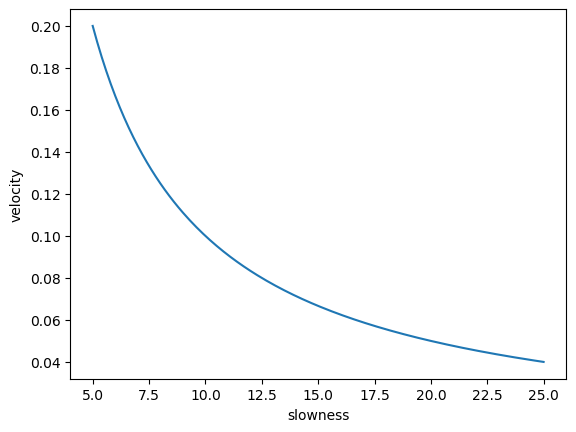

In [119]:
v(s) = 1 ./ s
dvds(s) = -1 ./ s.^2
Gv(G, s) = G .* transpose(1.0 ./ dvds(s))
s1 = range(5.0, 25.0, step=0.1)
plot(s1, v(s1))
xlabel("slowness")
ylabel("velocity");

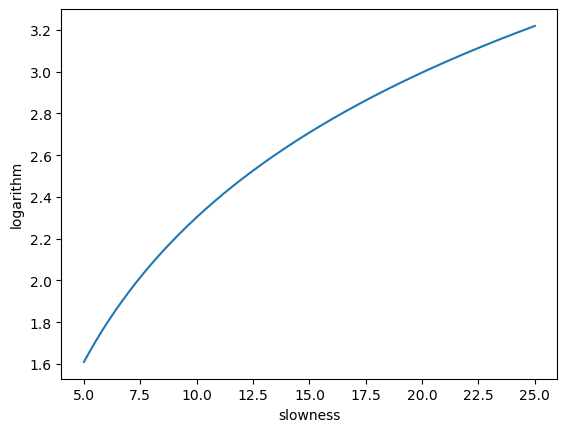

In [120]:
logs(s) = log.(s)
dlogds(s) = 1.0 ./ s
Glog(G, s) = G .* transpose(1 ./ dlogds(s))
plot(s1, logs(s1))
xlabel("slowness")
ylabel("logarithm");

We also consider the logarithmic barrier function
$$\hat{m}=\log(m-m_l)-\log(m_u-m)=\log\frac{m-m_l}{m_u-m}$$
with its derivative
$$\hat{m}'=\frac{1}{m-m_l} + \frac{1}{m_u-m}$$

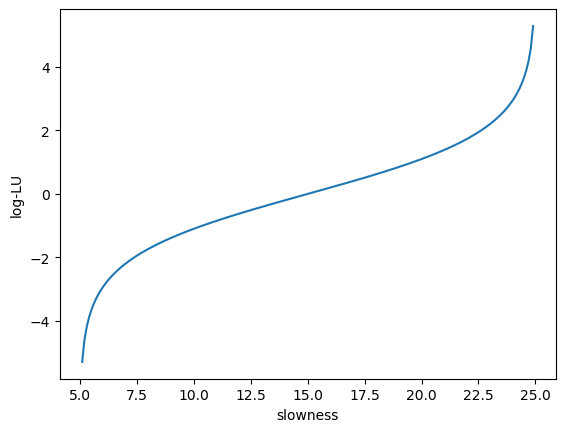

In [121]:
sL = 5
sU = 25
logLU(s) = log.((s .- sL) ./ (sU .- s))
dlogLUds(s) = 1.0 ./ (s-sL) + 1.0 ./ (sU-s)
GlogLU(G, s) = G * diagm(1 ./ dlogLUds(s))
plot(s1, logLU(s1))
xlabel("slowness")
ylabel("log-LU");

In [122]:
modelSyn = ones(nx, ny) * 10  # homogeneous
modelSyn[3:5, 4:6] .= 20  # anomaly
data = G * modelSyn[:]
data += randn(size(data)) * 1.0;

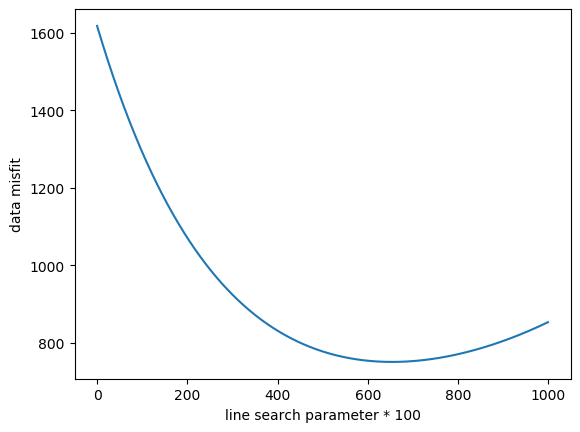

 419.11642512528346

In [125]:
# log-slowness inversion
slowness = ones(nM, 1) * 15
response = G * slowness
Gt = Glog(G, slowness)
s = svd(Gt)
lambda = s.S[1] / 20  # 10, 1, 0.1, 0.01
deltaData = data - G * slowness
print(" ", norm(deltaData))
deltaModel = inv(transpose(Gt) * Gt + IM * lambda^2) * (transpose(Gt) * deltaData)
misfit = zeros(1000)
for i = 1:length(misfit)
    logS = log.(slowness) .+ deltaModel * i / 100
    slowness1 = exp.(logS)
    misfit[i] = norm(G*slowness1)
end
plot(misfit)
xlabel("line search parameter * 100")
ylabel("data misfit");

 41.911642512528346 

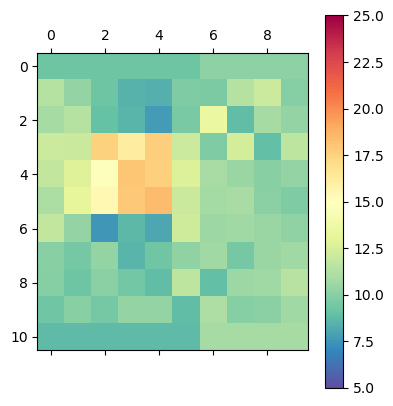

6.773946159305228 0.8972197820262477

In [129]:
# log-slowness inversion
lambda = 10
slowness = ones(nM, 1) * 15
response = G * slowness
for i = 1:3
    Gt = Glog(G, slowness)
    deltaData = data - G * slowness
    print(" ", norm(deltaData)/sqrt(length(data)))
    deltaModel = inv(transpose(Gt) * Gt + IM * lambda^2) * (transpose(Gt) * deltaData)
    logS = log.(slowness) .+ deltaModel
    slowness = exp.(logS)
end
showModel(slowness)

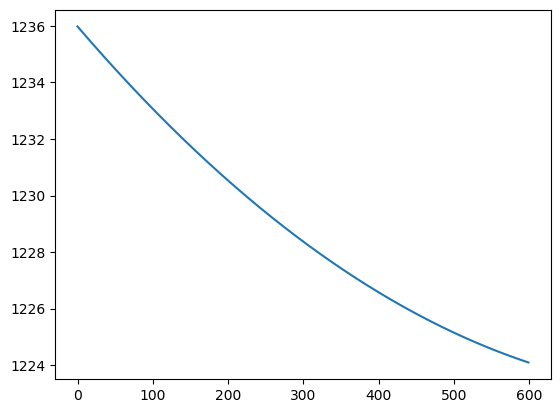

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000484C8688>

In [133]:
# look at line search
misfit = zeros(600, 1)
for i = 1:length(misfit)
    logS = log.(slowness) .+ deltaModel * i / 100
    slowness1 = exp.(logS)
    misfit[i] = norm(G*slowness1)
end
plot(misfit)

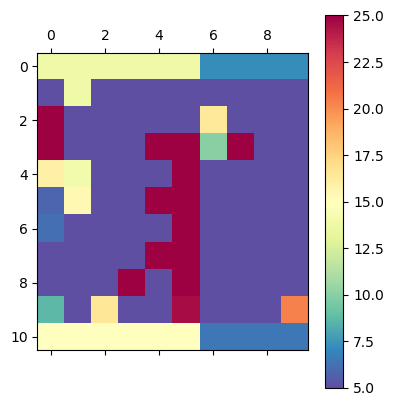

In [80]:
nM = size(G, 2)
IM = Matrix(I, nM, nM)  # identity matrix of size M
lambda = 0.5  # 10, 1, 0.1, 0.01
slowness = ones(nM, 1) * 15
response = G * slowness
for i = 1:3
    Gt = Gv(G, slowness)
    GtT = transpose(Gt)
    deltaData = data - G * slowness
    deltaModel = inv(GtT * Gt + IM * lambda^2) * (GtT * deltaData)
    velocity = 1.0 ./ slowness .+ deltaModel
    slowness = 1.0 ./ velocity
end
showModel(slowness)